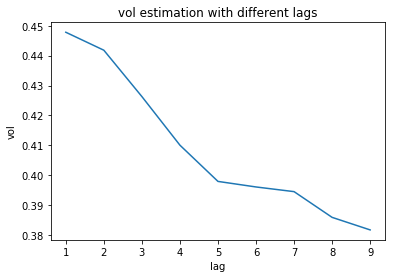

In [3]:
import config
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
from dateutil.parser import parse
import pdb

def get_market_time():
    """Create a dataframe with maket open periods    """
    df = pd.DataFrame(index = ["ag", "bu", "rb", "ru", "zn"], 
                      columns = ["day_period_1", "day_period_2", "day_period_3", "night_period_1"])
    df.index.name = "Instrument"
    df.columns.name = "open periods"
    #pdb.set_trace()
    for row in df.index:
        df.loc[row]["day_period_1"] = (dt.time(9, 0, 0), dt.time(10, 15, 0))
        df.loc[row]["day_period_2"] = (dt.time(10, 30, 0), dt.time(11, 30, 0))
        df.loc[row]["day_period_3"] = (dt.time(13, 30, 0), dt.time(15, 0, 0))
    for row in "ag", :
        df.loc[row]["night_period_1"] = (dt.time(21, 0, 0), dt.time(2, 30, 0))
    for row in "bu", "rb", "zn":
        df.loc[row]["night_period_1"] = (dt.time(21, 0, 0), dt.time(1, 0, 0))
    for row in "ru", :
        df.loc[row]["night_period_1"] = (dt.time(21, 0, 0), dt.time(11, 0, 0))
    return df

def clean_data(df):
    """Clean dataframe
    """
    # calculate datetime from timestamp
    #UTC8 = dt.timezone(dt.timedelta(hours = 8))
    #df["DateTime"] = df["TimeStamp"].apply(lambda x: dt.datetime.fromtimestamp(int(x)/1000, tz = UTC8))
    df["UpdateTime"] = df["UpdateTime"].apply(lambda x: parse(x).time())  
    
    # select data within makert time
    instrument = df["InstrumentID"][0][:2]
    market_time = get_market_time()
    mask = pd.Series(np.zeros(len(df))).astype(bool)
    for col in market_time.columns:
        mask = np.logical_or(mask, np.logical_and(df["UpdateTime"] >= market_time.loc[instrument][col][0], 
                                                  df["UpdateTime"] <= market_time.loc[instrument][col][1]))
    df = df[mask]
    return df


# def daily_vol(df, k = 1):
#     """Calculate daily volatility for dataframe.
#     """
#     vol = np.sqrt(vol_squared(df, k) /3.75 * 24 * 252)
#     return vol
        
def daily_vol(df, k = 1):
    """Calculate volatility for dataframe
    Inputs:
            df: dataframe, raw data of commodity futures price in a day
            k: int, lag used to calculate volatility
    Outputs:
            vol: float, volatility of the dataframe
    """

    s = df["LastPrice"].apply(np.log)
    x = (s - s.shift(k)).dropna()
    vol_squared = (np.sum(x * x) + np.sum((x * x.shift(-k)).dropna()) + np.sum((x * x.shift(k)).dropna())) / k
    market_time = get_market_time()
    hour = 3.75
    vol = np.sqrt(vol_squared / hour * 24 * 252)
    return vol
        
commodities = [name for name in os.listdir(config.DATA_BASE_PATH) if not name.startswith(".")] 
timesofdays = ["day", "night"]
opt_lag_max = []
opt_lag_min = []
for commodity in commodities[0], :
    for timesofday in timesofdays[0], :
        timesofday_path = os.path.join(config.DATA_BASE_PATH, commodity, timesofday)
        timesofday_files = os.listdir(timesofday_path)
        for timesofday_file in timesofday_files[:1] :
            timesofday_df = pd.read_csv(os.path.join(timesofday_path, timesofday_file))
            timesofday_df = clean_data(timesofday_df)
            #lags = range(1, 101, 1)
            lags = range(1, 10)
            vols = []
            for k in lags:
                vols.append(daily_vol(timesofday_df, k = k))
            opt_lag_max.append(lags[np.argmax(vols)])
            opt_lag_min.append(lags[np.argmin(vols)])
            plt.plot(lags, vols)
        plt.xlabel("lag")
        plt.ylabel("vol")
        plt.title("vol estimation with different lags")
        #plt.savefig(os.path.join(config.OUTPUT_PATH, "vol_lag.png"), dpi = 1000)
        #plt.close()
        

In [2]:
timesofday_df.shape

(1179, 37)